## Реализация алгоритма градиентного бустинга

Реализуем средствами Python алгоритм градиентного бустинга для деревьев решений.

Реализация деревьев решений была дважды продемонстрирована в предыдущих уроках, в этом не будем ее повторять и возьмем готовую реализацию дерева решений для регрессии из библиотеки `sklearn`.

In [205]:
from sklearn.tree import DecisionTreeRegressor

from sklearn import model_selection
import numpy as np

Используем один из "игрушечных" датасетов из той же библиотеки.

In [206]:
from sklearn.datasets import load_diabetes

In [207]:
X, y = load_diabetes(return_X_y=True)

Разделим выборку на обучающую и тестовую в соотношении 75/25.

In [208]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.25)

Напишем функцию, реализующую предсказание в градиентном бустинге.

In [209]:
def gb_predict(X, trees_list, coef_list, eta):
    # Реализуемый алгоритм градиентного бустинга будет инициализироваться нулевыми значениями,
    # поэтому все деревья из списка trees_list уже являются дополнительными и при предсказании прибавляются с шагом eta
    return np.array([sum([eta* coef * alg.predict([x])[0] for alg, coef in zip(trees_list, coef_list)]) for x in X])

В качестве функционала ошибки будем использовать среднеквадратичную ошибку. Реализуем соответствующую функцию.

In [210]:
def mean_squared_error(y_real, prediction):
    return (sum((y_real - prediction)**2)) / len(y_real)

Используем $L_{2}$ loss $L(y, z) = (y-z)^{2},$ ее производная по $z$ примет вид $L'(y, z) = 2(z-y)$. Реализуем ее также в виде функции (коэффициент 2 можно отбросить).

In [211]:
def bias(y, z):
    return (y - z)

Реализуем функцию обучения градиентного бустинга.

In [212]:
def gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta):
    
    # Деревья будем записывать в список
    trees = []
    
    # Будем записывать ошибки на обучающей и тестовой выборке на каждой итерации в список
    train_errors = []
    test_errors = []
    
    for i in range(n_trees):
        tree = DecisionTreeRegressor(max_depth=max_depth, random_state=42)

        # инициализируем бустинг начальным алгоритмом, возвращающим ноль, 
        # поэтому первый алгоритм просто обучаем на выборке и добавляем в список
        if len(trees) == 0:
            # обучаем первое дерево на обучающей выборке
            tree.fit(X_train, y_train)
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))
        else:
            # Получим ответы на текущей композиции
            target = gb_predict(X_train, trees, coefs, eta)
            
            # алгоритмы начиная со второго обучаем на сдвиг
            tree.fit(X_train, bias(y_train, target))
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))

        trees.append(tree)
        
    return trees, train_errors, test_errors

Теперь обучим несколько моделей с разными параметрами и исследуем их поведение.

In [213]:
# Число деревьев в ансамбле
n_trees = 10

# для простоты примем коэффициенты равными 1
coefs = [1] * n_trees

# Максимальная глубина деревьев
max_depth = 3

# Шаг
eta = 1

trees, train_errors, test_errors = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)

In [214]:
def evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta):
    train_prediction = gb_predict(X_train, trees, coefs, eta)

    print(f'Ошибка алгоритма из {n_trees} деревьев глубиной {max_depth} \
    с шагом {eta} на тренировочной выборке: {mean_squared_error(y_train, train_prediction)}')

    test_prediction = gb_predict(X_test, trees, coefs, eta)

    print(f'Ошибка алгоритма из {n_trees} деревьев глубиной {max_depth} \
    с шагом {eta} на тестовой выборке: {mean_squared_error(y_test, test_prediction)}')

In [215]:
evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta)

Ошибка алгоритма из 10 деревьев глубиной 3     с шагом 1 на тренировочной выборке: 1106.1393193054334
Ошибка алгоритма из 10 деревьев глубиной 3     с шагом 1 на тестовой выборке: 6049.764870642456


Построим графики зависимости ошибки на обучающей и тестовой выборках от числа итераций.

In [216]:
import matplotlib.pyplot as plt

In [217]:
def get_error_plot(n_trees, train_err, test_err):
    plt.xlabel('Iteration number')
    plt.ylabel('MSE')
    plt.xlim(0, n_trees)
    plt.plot(list(range(n_trees)), train_err, label='train error')
    plt.plot(list(range(n_trees)), test_err, label='test error')
    plt.legend(loc='upper right')
    plt.show()

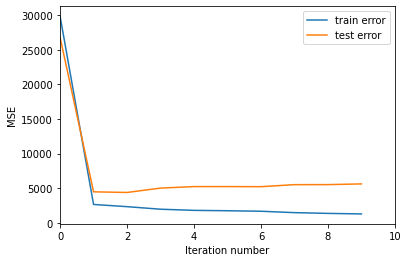

In [218]:
get_error_plot(n_trees, train_errors, test_errors)

Такой результат не является удовлетворительным

Увеличим число деревьев.

In [219]:
n_trees = 10
coefs = [1] * n_trees

trees, train_errors, test_errors = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)

In [220]:
evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta)

Ошибка алгоритма из 10 деревьев глубиной 3     с шагом 1 на тренировочной выборке: 1106.1393193054334
Ошибка алгоритма из 10 деревьев глубиной 3     с шагом 1 на тестовой выборке: 6049.764870642456


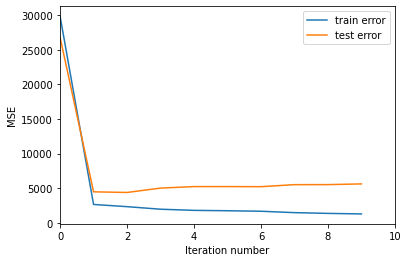

In [221]:
get_error_plot(n_trees, train_errors, test_errors)

Теперь попробуем уменьшить шаг.

In [222]:
eta = 0.1

trees, train_errors, test_errors = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)

In [223]:
evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta)

Ошибка алгоритма из 10 деревьев глубиной 3     с шагом 0.1 на тренировочной выборке: 5682.014181349823
Ошибка алгоритма из 10 деревьев глубиной 3     с шагом 0.1 на тестовой выборке: 6577.892931760869


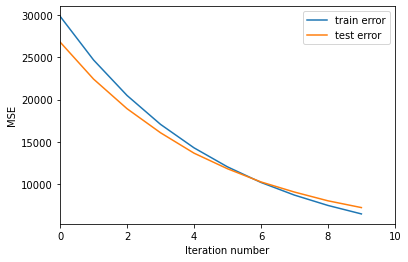

In [224]:
get_error_plot(n_trees, train_errors, test_errors)

Видим, что качество обучения улучшается.

Уменьшим шаг до 0.01.

In [225]:
eta = 0.01

trees, train_errors, test_errors = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)

In [226]:
evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta)

Ошибка алгоритма из 10 деревьев глубиной 3     с шагом 0.01 на тренировочной выборке: 24887.689508174095
Ошибка алгоритма из 10 деревьев глубиной 3     с шагом 0.01 на тестовой выборке: 22583.689480765646


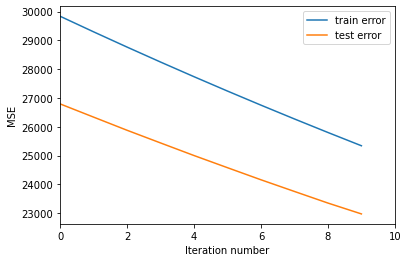

In [227]:
get_error_plot(n_trees, train_errors, test_errors)

При таком размере шага алгоритм сходится, но ему для достижения удовлетворительных показателей требуется большее количество итераций.

Вернемся к шагу 0.1 и попробуем увеличить глубину деревьев

In [228]:
eta = 0.1
max_depth = 5

trees, train_errors, test_errors = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)

In [229]:
evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta)

Ошибка алгоритма из 10 деревьев глубиной 5     с шагом 0.1 на тренировочной выборке: 4790.897638883269
Ошибка алгоритма из 10 деревьев глубиной 5     с шагом 0.1 на тестовой выборке: 6946.238320572974


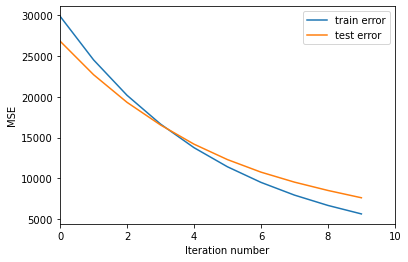

In [230]:
get_error_plot(n_trees, train_errors, test_errors)

Ошибка на обучающей выборке упала, а на тестовой несколько поднялась, то есть в данном случае можем говорить о появлении переобучения.

В целом, тут мы показали, что варьируя параметры обучения градиентного бустинга можно добиваться различного уровня точности модели.

Существуют различные реализации градиентного бустинга, и одна из самых популярных и широко используемых - XGBoost (в Python содержится в библиотеке с аналогичным названием). С этой реализацией можно ознакомиться в дополнительных материалах.

***

**Пострим графики влияния количества деревьев и глубины деревьев на ошибку модели**

In [231]:
def get_error_plot(n_trees, train_err, test_err):
    plt.xlabel('Iteration number')
    plt.ylabel('MSE')
    plt.xlim(0, n_trees)
    plt.plot(list(range(n_trees)), train_errors, label='train error')
    plt.plot(list(range(n_trees)), test_errors, label='test error')
    plt.legend(loc='upper right')
    plt.show()

In [232]:
n_trees_list = [10, 30, 50, 100]
max_depth_list = [3, 5, 7, 10]

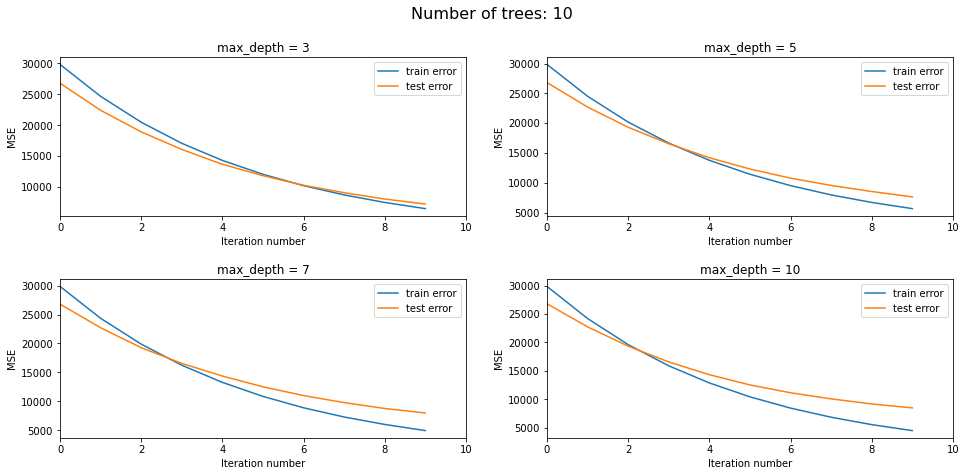

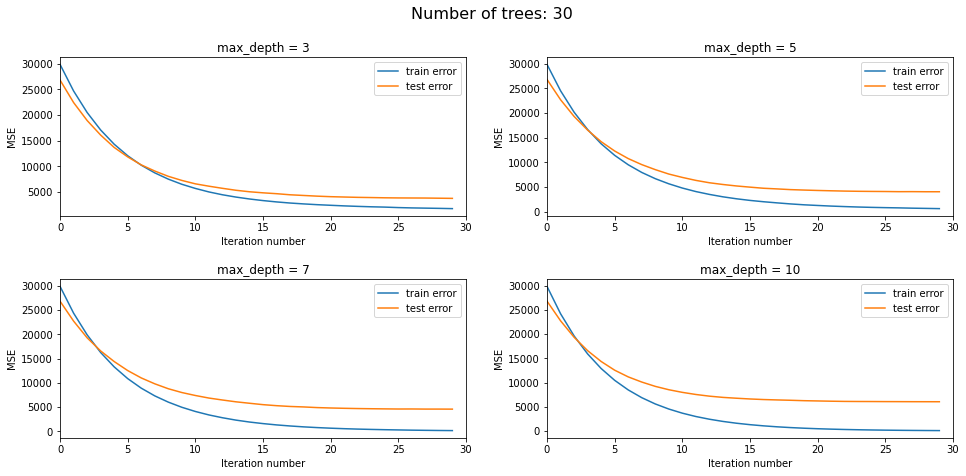

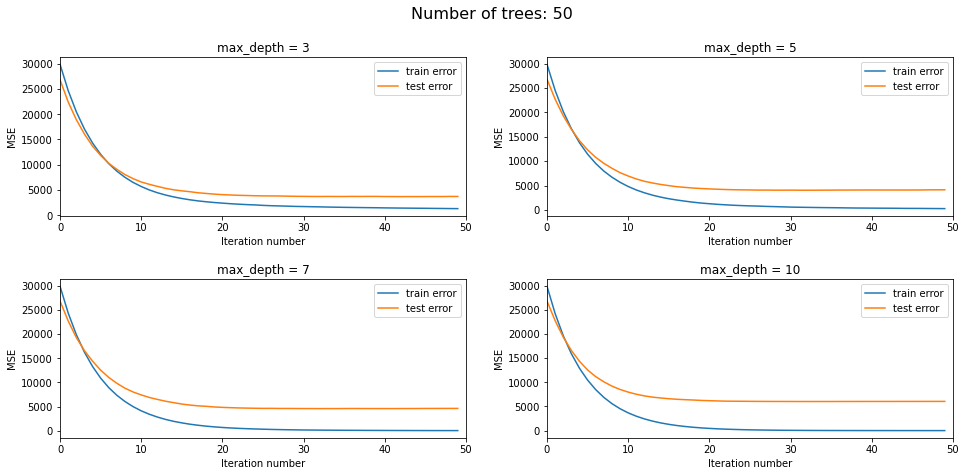

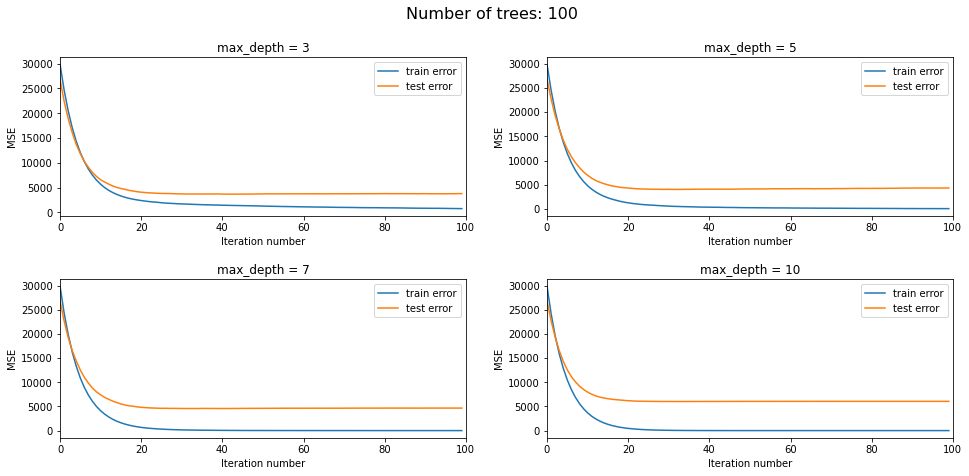

In [233]:
for tree in n_trees_list:
    fig = plt.figure(figsize = (16, 7))
    fig.suptitle(f'Number of trees: {tree}' , fontsize=16)
    plt.subplots_adjust(hspace=0.4)

    for idx, max_depth in enumerate(max_depth_list):
        
        eta = 0.1
        coefs = [1] * tree

        trees, train_errors, test_errors = gb_fit(tree, max_depth, X_train, X_test, y_train, y_test, coefs, eta)
        ax = fig.add_subplot(round(len(max_depth_list)/2), 2, idx+1)
        ax.set_title(f'max_depth = {max_depth}')
        ax.set_xlabel('Iteration number')
        ax.set_ylabel('MSE')
        ax.set_xlim(0, tree)
        ax.plot(list(range(tree)), train_errors, label='train error')
        ax.plot(list(range(tree)), test_errors, label='test error')
        ax.legend(loc='upper right')    
    plt.show()

**Реалзуем стохастический градиентный бустинг**

In [234]:
import random

random.seed(42)

def get_bootstrap_oob(data, labels, N):
    n_samples = data.shape[0]
    bootstrap = []
# добавляем список в котором будут храниться данные не попавшие в бутстрап выборку
    oob = []
    
    for i in range(N):
        b_data = []
        b_labels = []
        # сюда будем записывать индексы бутстрап выборки, в oob данные попадут все записи с индексами не входящими в этот список
        bootstrap_indeсes = []
        # n_samples //2 - выборка размером 0.5
        for j in range(int(n_samples * 0.5)):
            sample_index = random.randint(0, n_samples-1)
            b_data.append(data[sample_index])
            b_labels.append(labels[sample_index])
            bootstrap_indeсes.append(sample_index)
        bootstrap.append((np.array(b_data), np.array(b_labels)))
        #генерируем список для oob данных
        oob_data = [j for i,j in enumerate(data) if i not in bootstrap_indeсes]
        oob_labels = [j for i,j in enumerate(labels) if i not in bootstrap_indeсes]
        oob.append((np.array(oob_data), np.array(oob_labels)))
      
    return bootstrap, oob

In [235]:
def sgb_fit(n_trees, max_depth, X, y, coefs, eta):
    
    # Деревья будем записывать в список
    trees = []
    
    # Будем записывать ошибки на обучающей и тестовой выборке на каждой итерации в список
    train_errors = []
    test_errors = []
    
    for i in range(n_trees):
        tree = DecisionTreeRegressor(max_depth=max_depth, random_state=42)
        #Для каждого дерева будем генерировать бутстрап выборку
        bootstrap, oob = get_bootstrap_oob(X, y, 1)
        X_train = bootstrap[0][0]
        y_train = bootstrap[0][1]
        
        X_test = oob[0][0]
        y_test = oob[0][1]

        # инициализируем бустинг начальным алгоритмом, возвращающим ноль, 
        # поэтому первый алгоритм просто обучаем на выборке и добавляем в список
        if len(trees) == 0:
            # обучаем первое дерево на обучающей выборке
            tree.fit(X_train, y_train)
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))
        else:
            # Получим ответы на текущей композиции
            target = gb_predict(X_train, trees, coefs, eta)
            
            # алгоритмы начиная со второго обучаем на сдвиг
            tree.fit(X_train, bias(y_train, target))
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))

        trees.append(tree)
        
    return trees, train_errors, test_errors

In [236]:
# Число деревьев в ансамбле
n_trees = 100

# для простоты примем коэффициенты равными 1
coefs = [1] * n_trees

# Максимальная глубина деревьев
max_depth = 3

# Шаг
eta = 0.1

trees, train_errors, test_errors = sgb_fit(n_trees, max_depth, X, y, coefs, eta)

In [237]:
def get_error_plot(n_trees, test_err):
    plt.figure(figsize = (16, 7))
    plt.xlabel('Iteration number')
    plt.ylabel('MSE')
    plt.xlim(0, n_trees)
    plt.plot(list(range(n_trees)), test_err, label='test error')
    plt.legend(loc='upper right')
    plt.show()

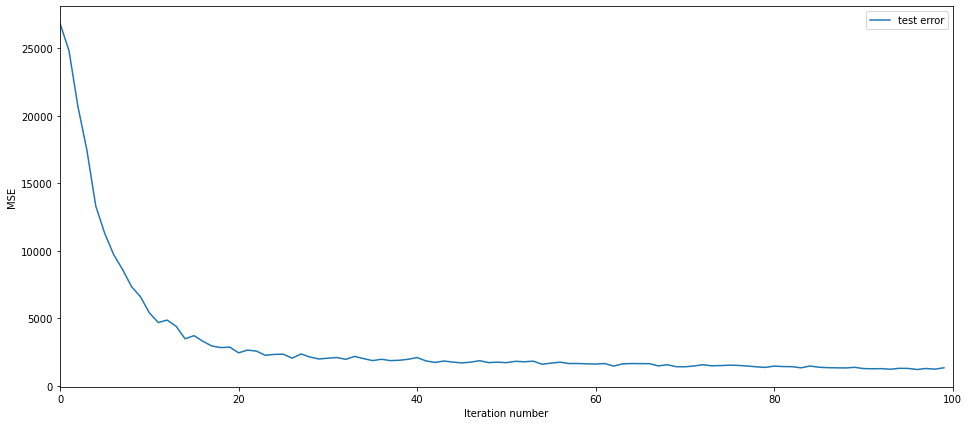

In [238]:
get_error_plot(n_trees, test_errors)

1. [Интерактивная демонстрация градиентного бустинга](http://arogozhnikov.github.io/2016/06/24/gradient_boosting_explained.html)
2. [sklearn.datasets](https://scikit-learn.org/stable/datasets/index.html)
3. [sklearn.tree.DecisionTreeRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html)
4. [$L_{1}$ loss и $L_{2}$ loss](https://afteracademy.com/blog/what-are-l1-and-l2-loss-functions)
5. [XGBoost](https://github.com/esokolov/ml-course-hse/blob/master/2016-fall/lecture-notes/lecture10-ensembles.pdf)
6. [AdaBoost](https://ru.wikipedia.org/wiki/AdaBoost)